# Inspect results

In [1]:
import numpy as np
import csv
import pandas as pd
import seaborn as sns
import os

from matplotlib import pyplot as plt

## Variables

In [2]:
FIGURES_DIR = os.path.join("/Users/tom/Desktop/PhD/ECG-RL/output/bonferonni/", "figures")

PARTICIPANTS_DIR = "/Users/tom/Desktop/PhD/Embodied-Communication-Game/output/data"
PARTICIPANTS_FIG_DIR = "/Users/tom/Desktop/PhD/Embodied-Communication-Game/output/figures"
PARTICIPANTS_Q_DIR = "/Users/tom/Desktop/PhD/Embodied-Communication-Game/output/questionnaire"

# RL_PATH = '/Users/tom/Desktop/PhD/ECG-RL/output/bonferonni/logs/LSTM_log-25000-20211119_113831-09999-08-08.npy'
RL_PATH = '/Users/tom/Desktop/PhD/ECG-RL/output/bonferonni/logs/LSTM_log-50000-20211124_170307-099995-08-08.npy'

segments = RL_PATH.split("-")
alpha = segments[5]
gamma = segments[6][:2]
epsilon_decay = segments[4]


## Helpers

In [3]:
def cumulative_reward(experiences):
    """
    Calculates the cummulative reward for an entire experience
    Input: list of experiences
    Returns: Sum (int)
    """
    return sum([move[2] for move in experiences])


def check_result(frame, index):
    """
    Checks whether a round finished succesfully or not
    Input: dataframe and index number for that round
    Returns: Boolean
    """
    return frame['result'][index]


def count_finish_colours(colours_df, agent):
    """
    Counts the number of times that an agent ended on a colour
    Input: colour dataframe and agentId
    Returns: Dictionary with colour and corresponding counts. 
    """
    unique, counts = np.unique([colours[agent] for colours in colours_df], return_counts=True)
    return dict(zip(unique, counts))


def convert_to_numbers(df, question_cols):
    """
    Converts the answers of the PNS questionnaire to numeric values between 1 and 6
    Input: dataframe with questionnaire answers and the column names
    Returns: dictionary with keys (question) and value list of (converted) answers
    """

    scores = {
    "Strongly disagree" : 1, 
    "Moderately disagree" : 2, 
    "Slightly disagree" : 3, 
    "Slighly agree" : 4, 
    "Moderately agree" : 5, 
    "Strongly agree" : 6
    }

    tmp_df = {}
    for q in question_cols:
        num_answers = []
        for answer in df[q]:
            num_answers.append(scores[answer])
        tmp_df[q + '_score'] = num_answers
    return tmp_df


# Data

### Load RL data

In [4]:
data_np = np.load(RL_PATH, allow_pickle=True)
# data = pd.read_csv(path, sep=',', converters={'time': str, 'p0_moves': eval, 'p1_moves': eval, 'colours': eval, 'experience1': eval, 'experience2': eval, 'grid1': eval, 'grid2': eval})
data_np = data_np.item()

data = pd.DataFrame(data_np).T
data.rename(columns={0: 'p0_moves', 1: 'p1_moves'}, inplace=True)


In [5]:
data["p0_num_moves"] = [len(round) for round in data.p0_moves]
data["p1_num_moves"] = [len(round) for round in data.p1_moves]
# data["reward"] = [50 if result else -5 for result in data.result]
data["cumulative_reward1"] = data.experience1.map(lambda experience : cumulative_reward(experience))
data["cumulative_reward2"] = data.experience2.map(lambda experience : cumulative_reward(experience))

data['p0_colour'] = [final_colours[0] for final_colours in data.colours]
data['p1_colour'] = [final_colours[1] for final_colours in data.colours]

data["average_cum_reward1"] = data.cumulative_reward1.rolling(1000).mean().shift(0)
data["average_cum_reward2"] = data.cumulative_reward2.rolling(1000).mean().shift(0)
data["max_cum_reward1"] = data.cumulative_reward1.rolling(1000).max().shift(0)
data["min_cum_reward1"] = data.cumulative_reward1.rolling(1000).min().shift(0)
data["max_cum_reward2"] = data.cumulative_reward2.rolling(1000).max().shift(0)
data["min_cum_reward2"] = data.cumulative_reward2.rolling(1000).min().shift(0)

data["average_steps1"] = data.p0_num_moves.rolling(1000).mean().shift(0)
data["average_steps2"] = data.p1_num_moves.rolling(1000).mean().shift(0)

data.head()

,result,time,colours,p0_moves,p1_moves,score,highscore,experience1,experience2,grid1,...,p0_colour,p1_colour,average_cum_reward1,average_cum_reward2,max_cum_reward1,min_cum_reward1,max_cum_reward2,min_cum_reward2,average_steps1,average_steps2
1,False,2021-11-24 17:03:10,"{0: 'red', 1: 'yellow'}",[finish],[finish],0,0,"[[[0, 3, 0, 0, 2, 0, 1, 9, 9, 9, 9, 9, 9, 9, 9...","[[[3, 0, 3, 2, 1, 0, 3, 9, 9, 9, 9, 9, 9, 9, 9...","{0: 'red', 1: 'blue', 2: 'red', 3: 'lime'}",...,red,yellow,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,False,2021-11-24 17:03:25,"{0: 'red', 1: 'lime'}","[nothing, nothing, nothing, nothing, nothing, ...","[nothing, nothing, nothing, nothing, nothing, ...",0,0,"[[[0, 1, 0, 0, 0, 1, 1, 9, 9, 9, 9, 9, 9, 9, 9...","[[[1, 0, 1, 1, 1, 0, 0, 9, 9, 9, 9, 9, 9, 9, 9...","{0: 'red', 1: 'red', 2: 'lime', 3: 'lime'}",...,red,lime,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,True,2021-11-24 17:03:30,"{0: 'lime', 1: 'lime'}","[r, d, d, d, d, d, d, d, d, d, d, d, d, d, d, ...","[r, d, d, d, d, d, d, d, d, d, d, d, d, d, d, ...",1,1,"[[[0, 1, 1, 1, 1, 0, 1, 9, 9, 9, 9, 9, 9, 9, 9...","[[[1, 3, 2, 3, 2, 3, 1, 9, 9, 9, 9, 9, 9, 9, 9...","{0: 'lime', 1: 'lime', 2: 'red', 3: 'lime'}",...,lime,lime,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,False,2021-11-24 17:03:33,"{0: 'yellow', 1: 'lime'}","[l, u, u, u, u, u, u, u, u, u, u, u, u, u, u, ...","[l, u, u, u, u, u, u, u, u, u, u, u, u, u, u, ...",0,1,"[[[3, 0, 0, 3, 0, 3, 0, 9, 9, 9, 9, 9, 9, 9, 9...","[[[0, 0, 1, 1, 2, 3, 3, 9, 9, 9, 9, 9, 9, 9, 9...","{0: 'yellow', 1: 'red', 2: 'yellow', 3: 'red'}",...,yellow,lime,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,False,2021-11-24 17:03:37,"{0: 'red', 1: 'lime'}","[l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, ...","[l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, ...",0,1,"[[[1, 1, 1, 3, 1, 0, 3, 9, 9, 9, 9, 9, 9, 9, 9...","[[[1, 2, 1, 1, 1, 0, 0, 9, 9, 9, 9, 9, 9, 9, 9...","{0: 'yellow', 1: 'lime', 2: 'red', 3: 'yellow'}",...,red,lime,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
data.columns

Index(['result', 'time', 'colours', 'p0_moves', 'p1_moves', 'score',
       'highscore', 'experience1', 'experience2', 'grid1', 'grid2',
       'p0_num_moves', 'p1_num_moves', 'cumulative_reward1',
       'cumulative_reward2', 'p0_colour', 'p1_colour', 'average_cum_reward1',
       'average_cum_reward2', 'max_cum_reward1', 'min_cum_reward1',
       'max_cum_reward2', 'min_cum_reward2', 'average_steps1',
       'average_steps2'],
      dtype='object')

In [7]:
print(data["result"].value_counts())
percentage = (data["result"].value_counts()[True] / (data["result"].value_counts()[True] + data["result"].value_counts()[False]))
print("percentage correct:", percentage)

False    37220
True     12780
Name: result, dtype: int64
percentage correct: 0.2556


### Load questionnaire data

Questionnaire
PNS - Personal Need for Strucute
F1 - the desire for structure -- 3 4 6 10
F2 - the response to the lack of structure -- 1 2 5 7 8 9 11 12

Questions
1. It upsets me to go into a situation without knowing what I can expect from it
2. I am not bothered by things that upset my daily routine
3. I enjoy having a clear and structured mode of life
4. I like a place for everything and everything in its place
5. I like being spontaneous
6. I find that a well-ordered life with regular hours makes my life tedious
7. I do not like situations that are uncertain
8. I hate to change my plans at the last minute
9. I hate to be with people that are unpredictable
10. I find that a consistent routine enables me to enjoy life more
11. I enjoy the exhilaration of being put in unpredictable situations
12. I become uncomfortable when the rules in a situation are not clear

Scores
Strongly disagree = 1, Moderately disagree = 2, Slightly disagree = 3, Slighly agree = 4, Moderately agree = 5, Strongly agree = 6



In [8]:
questionnaire_data_df = pd.read_csv(os.path.join(PARTICIPANTS_Q_DIR, "Questionnaire 22-06-2021_December 2, 2021_07.50.csv"), sep=',')
questionnaire_data_df.drop(labels= [0,1], axis=0, inplace=True)
questionnaire_data_df.reset_index(inplace=True)
questionnaire_data_df.drop(labels= ['index', 'RecipientLastName', 'RecipientFirstName', 'ResponseId', 'Status', 'ExternalReference', 'RecipientEmail', 'DistributionChannel', 'UserLanguage', 'Q_RecaptchaScore', 'LocationLatitude', 'LocationLongitude', 'IPAddress', 'Progress'], axis=1, inplace=True)
# questionnaire_data_df.head()

In [9]:
question_cols = ['Q3_1', 'Q3_2', 'Q3_3', 'Q3_4', 'Q3_5', 'Q3_6', 'Q3_7', 'Q3_8', 'Q3_9', 'Q3_10', 'Q3_11', 'Q3_12']
question_score_cols = ['Q3_1_score', 'Q3_2_score', 'Q3_3_score', 'Q3_4_score', 'Q3_5_score', 'Q3_6_score', 'Q3_7_score', 'Q3_8_score', 'Q3_9_score', 'Q3_10_score', 'Q3_11_score', 'Q3_12_score']
F1_score_cols = ['Q3_3_score', 'Q3_4_score', 'Q3_6_score', 'Q3_10_score']
F2_score_cols = ['Q3_1_score', 'Q3_2_score', 'Q3_5_score', 'Q3_7_score', 'Q3_8_score', 'Q3_9_score', 'Q3_11_score', 'Q3_12_score']

answer_dict = convert_to_numbers(questionnaire_data_df, question_cols)

questionnaire_data_df = questionnaire_data_df.join(pd.DataFrame(answer_dict))

In [10]:
questionnaire_data_df['PNS_score'] = questionnaire_data_df[question_score_cols].sum(axis=1)
questionnaire_data_df['F1_score'] = questionnaire_data_df[F1_score_cols].sum(axis=1)
questionnaire_data_df['F2_score'] = questionnaire_data_df[F2_score_cols].sum(axis=1)


In [11]:
questionnaire_data_df.head()

,StartDate,EndDate,Duration (in seconds),Finished,RecordedDate,Q1,Q2,Q3_1,Q3_2,Q3_3,...,Q3_6_score,Q3_7_score,Q3_8_score,Q3_9_score,Q3_10_score,Q3_11_score,Q3_12_score,PNS_score,F1_score,F2_score
0,2021-11-17 09:01:59,2021-11-17 09:05:30,210,True,2021-11-17 09:05:30,FR7rw,ch4wOT8StB,Moderately agree,Strongly disagree,Moderately agree,...,6,5,4,4,3,2,4,49,19,30
1,2021-11-17 09:02:08,2021-11-17 09:08:11,362,True,2021-11-17 09:08:13,5yp6Q,OV3GvNyneB,Moderately agree,Moderately agree,Slighly agree,...,5,4,4,3,3,3,4,49,17,32
2,2021-11-17 09:02:12,2021-11-17 09:09:37,445,True,2021-11-17 09:09:37,0eJ6m,ch4wOT8StB,Moderately disagree,Moderately agree,Slighly agree,...,3,2,2,2,4,6,2,41,14,27
3,2021-11-17 09:09:44,2021-11-17 09:11:35,110,True,2021-11-17 09:11:35,'-mB45,OV3GvNyneB,Moderately disagree,Moderately agree,Slighly agree,...,3,2,2,2,4,5,2,40,14,26
4,2021-11-19 06:12:05,2021-11-19 06:18:07,361,True,2021-11-19 06:18:07,ggK-f,jAw3vrzJy4,Moderately disagree,Slightly disagree,Moderately agree,...,3,5,4,4,3,4,4,46,15,31


In [12]:
questionnaire_data_df.columns

Index(['StartDate', 'EndDate', 'Duration (in seconds)', 'Finished',
       'RecordedDate', 'Q1', 'Q2', 'Q3_1', 'Q3_2', 'Q3_3', 'Q3_4', 'Q3_5',
       'Q3_6', 'Q3_7', 'Q3_8', 'Q3_9', 'Q3_10', 'Q3_11', 'Q3_12', 'Q4', 'Q5',
       'Q6', 'Q3_1_score', 'Q3_2_score', 'Q3_3_score', 'Q3_4_score',
       'Q3_5_score', 'Q3_6_score', 'Q3_7_score', 'Q3_8_score', 'Q3_9_score',
       'Q3_10_score', 'Q3_11_score', 'Q3_12_score', 'PNS_score', 'F1_score',
       'F2_score'],
      dtype='object')

### Load participant game data

In [13]:
file_names = [os.path.join(PARTICIPANTS_DIR, f) for f in os.listdir(PARTICIPANTS_DIR) if os.path.isfile(os.path.join(PARTICIPANTS_DIR, f)) and '.csv' in f]

list_of_dfs = []

for filename in file_names:
    df = pd.read_csv(filename, index_col=None, header=0, sep=',', converters={'time': str, 'p0_moves': eval, 'p1_moves': eval, 'colours': eval, 'experience1': eval, 'experience2': eval, 'grid1': eval, 'grid2': eval})
    
    for i, experience in enumerate(df.experience1):
        if check_result(df, i):
            df.experience1[i][-1][2] = 50
            df.experience2[i][-1][2] = 50   
        else:
            df.experience1[i][-1][2] = -5
            df.experience2[i][-1][2] = -5
    
    df["p0_num_moves"] = [len(round) for round in df.p0_moves]
    df["p1_num_moves"] = [len(round) for round in df.p1_moves]

    df['p0_colour'] = [final_colours[0] for final_colours in df.colours]
    df['p1_colour'] = [final_colours[1] for final_colours in df.colours]

    # df["reward"] = [50 if result else -5 for result in df.result]
    df["cumulative_reward1"] = df.experience1.map(lambda experience : cumulative_reward(experience))
    df["cumulative_reward2"] = df.experience2.map(lambda experience : cumulative_reward(experience))

    df["average_cum_reward1"] = df.cumulative_reward1.rolling(10).mean().shift(0)
    df["average_cum_reward2"] = df.cumulative_reward2.rolling(10).mean().shift(0)

    df["average_steps1"] = df.p0_num_moves.rolling(10).mean().shift(0)
    df["average_steps2"] = df.p1_num_moves.rolling(10).mean().shift(0)
    
    list_of_dfs.append(df)

big_frame = pd.concat(list_of_dfs, axis=0, ignore_index=True)

In [29]:
big_frame.columns

Index(['time', 'round', 'p0_moves', 'p1_moves', 'colours', 'result', 'score',
       'highscore', 'experience1', 'experience2', 'grid1', 'grid2',
       'p0_gender', 'p0_age', 'p1_gender', 'p1_age', 'gameId', 'p0_id',
       'p1_id', 'p0_date', 'p1_date', 'p0_consent', 'p1_consent',
       'p0_num_moves', 'p1_num_moves', 'p0_colour', 'p1_colour',
       'cumulative_reward1', 'cumulative_reward2', 'average_cum_reward1',
       'average_cum_reward2', 'average_steps1', 'average_steps2'],
      dtype='object')

In [15]:
gameId_list = []
for gameId in big_frame['gameId'].value_counts().keys():
    for player in ['p0_colour', 'p1_colour']:
        a = big_frame[big_frame['gameId'] == gameId][player].value_counts()
        # print(a)
        # b = big_frame[big_frame['gameId'] == gameId]['p1_colour'].value_counts()
        tmp_df = pd.DataFrame(a.keys(), a.values)

        tmp_df['gameId'] = gameId
        tmp_df['playerId'] = player

        gameId_list.append(tmp_df)
        
colour_gameId_df = pd.concat(gameId_list).reset_index()

colour_gameId_df.rename(columns={'index':'count', 0:'colour'}, inplace=True)

## Join data

In [ ]:
master_df = pd.merge(questionnaire_data_df, big_frame, how='left', on=[''])

# Plots

In [16]:
sns.set_theme(style="whitegrid")

## RL Plots

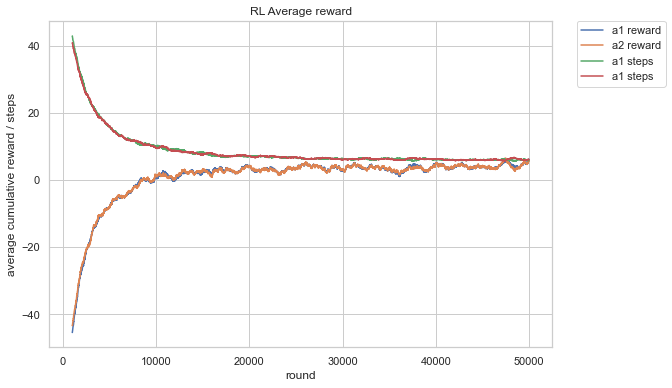

In [171]:
plt.figure(figsize=(9,6))
plt.title("RL Average reward")

sns.lineplot(data=data, x=data.index, y="average_cum_reward1", label="a1 reward")
sns.lineplot(data=data, x=data.index, y="average_cum_reward2", label="a2 reward")

sns.lineplot(data=data, x=data.index, y="average_steps1", label="a1 steps")
sns.lineplot(data=data, x=data.index, y="average_steps2", label="a1 steps")


plt.ylabel("average cumulative reward / steps")
plt.xlabel("round")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.savefig(os.path.join(FIGURES_DIR, f"reward-steps-{len(data)}-{alpha}-{gamma}-{epsilon_decay}.png"),
            dpi=300, 
            format='png', 
            bbox_inches='tight')

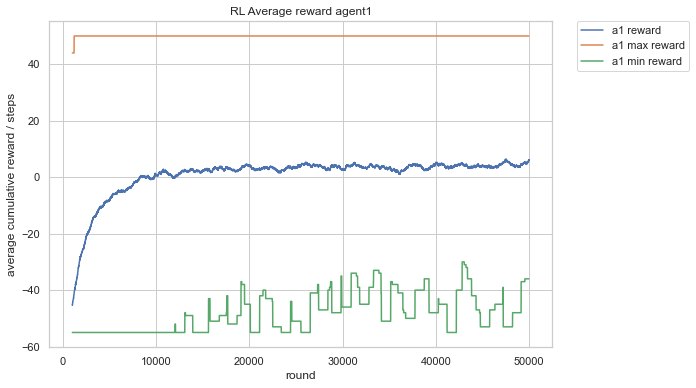

In [17]:
plt.figure(figsize=(9,6))
plt.title("RL Average reward agent1")

sns.lineplot(data=data, x=data.index, y="average_cum_reward1", label="a1 reward")
sns.lineplot(data=data, x=data.index, y="max_cum_reward1", label="a1 max reward")
sns.lineplot(data=data, x=data.index, y="min_cum_reward1", label="a1 min reward")

plt.ylabel("average cumulative reward / steps")
plt.xlabel("round")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

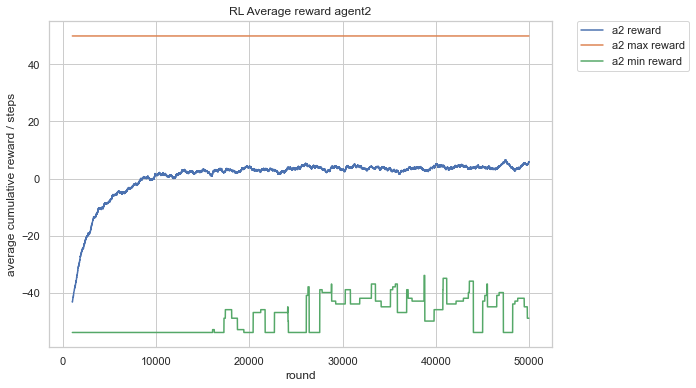

In [173]:
plt.figure(figsize=(9,6))
plt.title("RL Average reward agent2")
sns.set_theme(style="whitegrid")
sns.lineplot(data=data, x=data.index, y="average_cum_reward2", label="a2 reward")
# sns.lineplot(data=data, x=data.index, y="average_reward2")
sns.lineplot(data=data, x=data.index, y="max_cum_reward2", label="a2 max reward")
sns.lineplot(data=data, x=data.index, y="min_cum_reward2", label="a2 min reward")

plt.ylabel("average cumulative reward / steps")
plt.xlabel("round")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

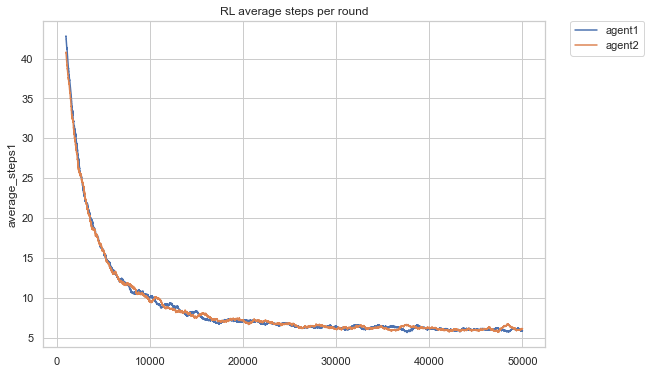

In [174]:
plt.figure(figsize=(9,6))
plt.title("RL average steps per round")

sns.lineplot(data=data, x=data.index, y="average_steps1", label="agent1")
sns.lineplot(data=data, x=data.index, y="average_steps2", label="agent2")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

<AxesSubplot:xlabel='p1_colour', ylabel='count'>

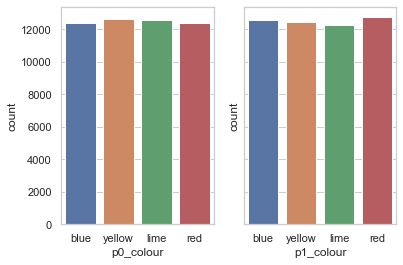

In [13]:
fig, axs = plt.subplots(1, 2, sharey=True)
sns.countplot(x='p0_colour', data=data, ax=axs[0], order=["blue","yellow","lime","red"])
sns.countplot(x='p1_colour', data=data, ax=axs[1], order=["blue","yellow","lime","red"])


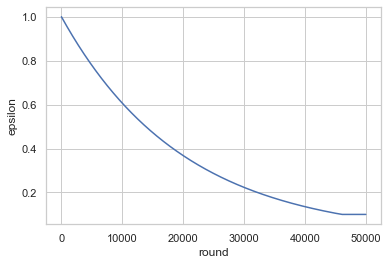

In [18]:
epsilon = 1.0
epsilon_min = 0.1
epsilon_decay = 0.99995
test = []
for i in range(50000):
  if epsilon > epsilon_min:
    epsilon *= epsilon_decay
  test.append(epsilon)

plt.plot(test)
plt.xlabel("round")
plt.ylabel("epsilon")
plt.show()

## Participant plots

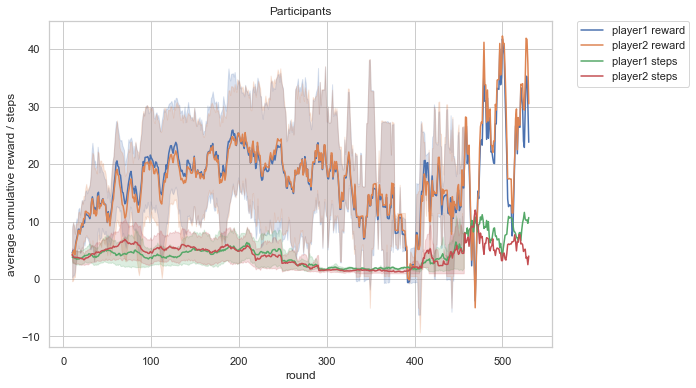

In [19]:
plt.figure(figsize=(9,6))
sns.lineplot(data=big_frame, x=big_frame['round'], y="average_cum_reward1", label="player1 reward")
sns.lineplot(data=big_frame, x=big_frame['round'], y="average_cum_reward2", label="player2 reward")

sns.lineplot(data=big_frame, x=big_frame['round'], y="average_steps1", label="player1 steps")
sns.lineplot(data=big_frame, x=big_frame['round'], y="average_steps2", label="player2 steps")


plt.ylabel("average cumulative reward / steps")
plt.xlabel("round")
plt.title("Participants")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.savefig(os.path.join(PARTICIPANTS_FIG_DIR, f"reward-steps-participants.png"),
            dpi=300, 
            format='png', 
            bbox_inches='tight')

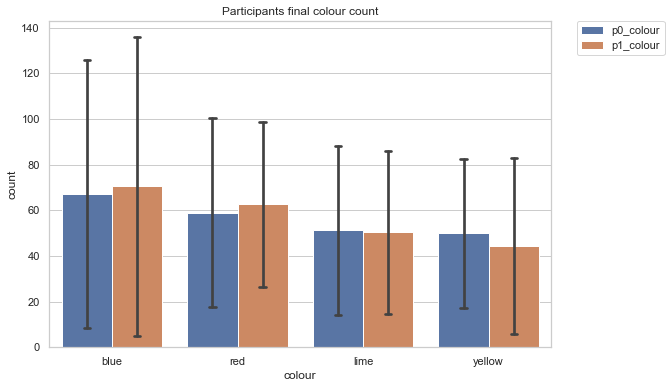

In [20]:
plt.figure(figsize=(9,6))
sns.barplot(x='colour', y='count', hue='playerId', data = colour_gameId_df, ci='sd', capsize=.05)
plt.title("Participants final colour count")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.savefig(os.path.join(PARTICIPANTS_FIG_DIR, f"final-colour-participants.png"),
            dpi=300, 
            format='png', 
            bbox_inches='tight')

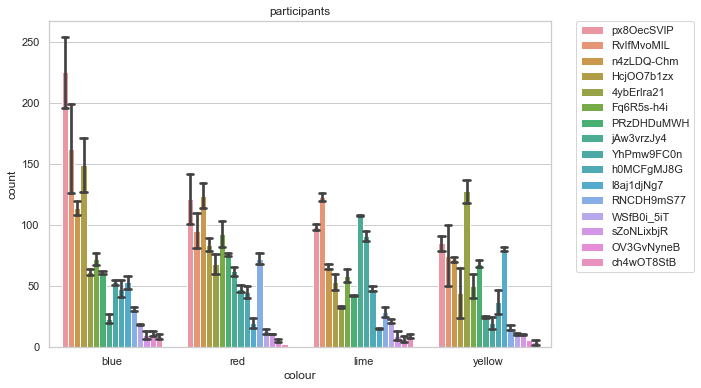

In [21]:
plt.figure(figsize=(9,6))
sns.barplot(x='colour', y='count', hue='gameId', data = colour_gameId_df, ci='sd', capsize=.05)
plt.title("participants")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Single Participants

In [22]:
participant_data = pd.read_csv("/Users/tom/Desktop/PhD/Embodied-Communication-Game/output/data/l8aj1djNg7.csv", sep=',', converters={'time': str, 'p0_moves': eval, 'p1_moves': eval, 'colours': eval, 'experience1': eval, 'experience2': eval, 'grid1': eval, 'grid2': eval})

#### numpy reading

In [23]:
array = np.load("/Users/tom/Desktop/PhD/Embodied-Communication-Game/output/data/RNCDH9mS77.npy", allow_pickle=True)
array_np = array.item()

test = pd.DataFrame(array_np).T
test.columns

Index(['result', 'time', 'colours', 'SNkl0', 'HK_0D', 'score', 'highscore',
       'experience1', 'experience2', 'grid1', 'grid2'],
      dtype='object')

#### Continue

In [24]:
for i, experience in enumerate(participant_data.experience1):
    if check_result(participant_data, i):
        participant_data.experience1[i][-1][2] = 50
        participant_data.experience2[i][-1][2] = 50
    else:
        participant_data.experience1[i][-1][2] = -5
        participant_data.experience2[i][-1][2] = -5

participant_data["p0_num_moves"] = [len(round) for round in participant_data.p0_moves]
participant_data["p1_num_moves"] = [len(round) for round in participant_data.p1_moves]

participant_data['p0_colour'] = [final_colours[0] for final_colours in participant_data.colours]
participant_data['p1_colour'] = [final_colours[1] for final_colours in participant_data.colours]

# participant_data["reward"] = [50 if result else -5 for result in participant_data.result]
participant_data["cumulative_reward1"] = participant_data.experience1.map(lambda experience : cumulative_reward(experience))
participant_data["cumulative_reward2"] = participant_data.experience2.map(lambda experience : cumulative_reward(experience))

participant_data["average_cum_reward1"] = participant_data.cumulative_reward1.rolling(10).mean().shift(0)
participant_data["average_cum_reward2"] = participant_data.cumulative_reward2.rolling(10).mean().shift(0)
participant_data["max_cum_reward1"] = participant_data.cumulative_reward1.rolling(10).max().shift(0)
participant_data["min_cum_reward1"] = participant_data.cumulative_reward1.rolling(10).min().shift(0)
participant_data["max_cum_reward2"] = participant_data.cumulative_reward2.rolling(10).max().shift(0)
participant_data["min_cum_reward2"] = participant_data.cumulative_reward2.rolling(10).min().shift(0)

participant_data["average_steps1"] = participant_data.p0_num_moves.rolling(10).mean().shift(0)
participant_data["average_steps2"] = participant_data.p1_num_moves.rolling(10).mean().shift(0)

In [25]:
participant_data.head()

,time,round,p0_moves,p1_moves,colours,result,score,highscore,experience1,experience2,...,cumulative_reward1,cumulative_reward2,average_cum_reward1,average_cum_reward2,max_cum_reward1,min_cum_reward1,max_cum_reward2,min_cum_reward2,average_steps1,average_steps2
0,2021-12-04 18:41:20,1,"[(r, 2021-12-04 18:41:35), (finish, 2021-12-04...","[(u, 2021-12-04 18:41:25), (r, 2021-12-04 18:4...","{0: 'blue', 1: 'red'}",False,0,0,"[[[0, 0, 1, 1, 1, 1, 2, 9, 9, 9, 9, 9, 9, 9, 9...","[[[2, 0, 1, 3, 2, 1, 0, 9, 9, 9, 9, 9, 9, 9, 9...",...,-6,-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-12-04 18:41:57,2,"[(d, 2021-12-04 18:42:10), (l, 2021-12-04 18:4...","[(r, 2021-12-04 18:41:59), (d, 2021-12-04 18:4...","{0: 'blue', 1: 'blue'}",True,1,1,"[[[3, 3, 3, 1, 2, 1, 3, 9, 9, 9, 9, 9, 9, 9, 9...","[[[0, 3, 2, 2, 2, 3, 2, 9, 9, 9, 9, 9, 9, 9, 9...",...,45,48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-12-04 18:42:25,3,"[(l, 2021-12-04 18:42:28), (u, 2021-12-04 18:4...","[(r, 2021-12-04 18:42:27), (finish, 2021-12-04...","{0: 'red', 1: 'red'}",True,2,2,"[[[1, 1, 3, 0, 3, 2, 3, 9, 9, 9, 9, 9, 9, 9, 9...","[[[0, 1, 1, 1, 0, 0, 3, 9, 9, 9, 9, 9, 9, 9, 9...",...,46,49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-12-04 18:42:43,4,"[(l, 2021-12-04 18:42:45), (u, 2021-12-04 18:4...","[(l, 2021-12-04 18:42:46), (u, 2021-12-04 18:4...","{0: 'lime', 1: 'yellow'}",False,0,2,"[[[1, 1, 2, 1, 2, 1, 0, 9, 9, 9, 9, 9, 9, 9, 9...","[[[3, 2, 2, 1, 0, 3, 2, 9, 9, 9, 9, 9, 9, 9, 9...",...,-8,-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-12-04 18:43:03,5,"[(d, 2021-12-04 18:43:05), (u, 2021-12-04 18:4...","[(l, 2021-12-04 18:43:06), (r, 2021-12-04 18:4...","{0: 'blue', 1: 'lime'}",False,0,2,"[[[0, 0, 2, 2, 3, 2, 2, 9, 9, 9, 9, 9, 9, 9, 9...","[[[1, 2, 3, 1, 3, 0, 0, 9, 9, 9, 9, 9, 9, 9, 9...",...,-9,-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
participant_data.columns

Index(['time', 'round', 'p0_moves', 'p1_moves', 'colours', 'result', 'score',
       'highscore', 'experience1', 'experience2', 'grid1', 'grid2',
       'p0_gender', 'p0_age', 'p1_gender', 'p1_age', 'gameId', 'p0_id',
       'p1_id', 'p0_date', 'p1_date', 'p0_consent', 'p1_consent',
       'p0_num_moves', 'p1_num_moves', 'p0_colour', 'p1_colour',
       'cumulative_reward1', 'cumulative_reward2', 'average_cum_reward1',
       'average_cum_reward2', 'max_cum_reward1', 'min_cum_reward1',
       'max_cum_reward2', 'min_cum_reward2', 'average_steps1',
       'average_steps2'],
      dtype='object')

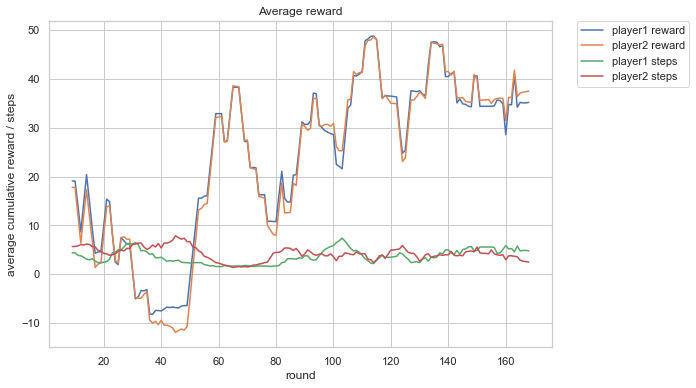

In [27]:
plt.figure(figsize=(9,6))
plt.title("Average reward")

sns.lineplot(data=participant_data, x=participant_data.index, y="average_cum_reward1", label="player1 reward")
sns.lineplot(data=participant_data, x=participant_data.index, y="average_cum_reward2", label="player2 reward")

sns.lineplot(data=participant_data, x=participant_data.index, y="average_steps1", label="player1 steps")
sns.lineplot(data=participant_data, x=participant_data.index, y="average_steps2", label="player2 steps")


plt.ylabel("average cumulative reward / steps")
plt.xlabel("round")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# plt.savefig(os.path.join(FIGURES_DIR, f"reward-steps-{len(data)}-{alpha}-{gamma}-{epsilon_decay}.png"),
#             dpi=300, 
#             format='png', 
#             bbox_inches='tight')

<AxesSubplot:xlabel='p1_colour', ylabel='count'>

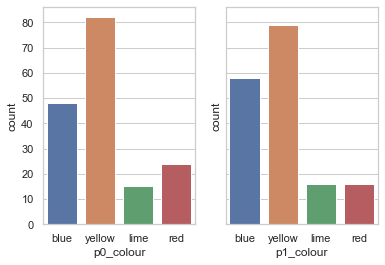

In [28]:
fig, axs = plt.subplots(1, 2, sharey=True)
sns.countplot(x='p0_colour', data=participant_data, ax=axs[0], order=["blue","yellow","lime","red"])
sns.countplot(x='p1_colour', data=participant_data, ax=axs[1], order=["blue","yellow","lime","red"])